In [3]:
pip cache purge

Files removed: 868 (358.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Hide tqdm warning once and for all
import warnings
warnings.filterwarnings("ignore", message="IProgress not found")

# Silver Price Analysis & Forecasting (2016–2026)
**By Ferved**  
**Date**: February 2026  
**Goal**: Aanalysis + future prediction of historical silver prices(Q1 2026 tak)

Steps in this notebook:
1. Data fetch & load
2. Data cleaning
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Model Training (Random Forest + Prophet)
6. Evaluation & Forecast
7. Conclusion

## Imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Models
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data fetch
import yfinance as yf

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("mako")
%matplotlib inline

## Data Fetching from yfinance

In [15]:
print("Fetching fresh silver futures data (SI=F)...")
df_raw = yf.download('SI=F', start='2016-01-01', end='2026-02-13')

# Save kar lete hain
df_raw.to_csv('silver_prices_raw.csv')

print("Data downloaded!")
print("Rows:", len(df_raw))
print(df_raw.tail(5))

Fetching fresh silver futures data (SI=F)...


[*********************100%***********************]  1 of 1 completed

Data downloaded!
Rows: 2542
Price           Close       High        Low       Open Volume
Ticker           SI=F       SI=F       SI=F       SI=F   SI=F
Date                                                         
2026-02-06  76.735001  77.320000  68.709999  70.404999    118
2026-02-09  82.065002  82.065002  79.980003  80.504997    443
2026-02-10  80.218002  81.675003  79.839996  81.675003    112
2026-02-11  83.753998  84.470001  80.985001  80.995003    112
2026-02-12  83.150002  84.875000  81.125000  84.125000  14096


## Data Load & Basic Cleaning

In [16]:
df = df_raw.copy()

# Simple columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df = df.dropna()

print("Cleaned shape:", df.shape)
print(df.head())
print(df.tail())

Cleaned shape: (2542, 5)
Price         Open    High     Low   Close Volume
Ticker        SI=F    SI=F    SI=F    SI=F   SI=F
Date                                             
2016-01-04  14.100  14.100  13.817  13.817     27
2016-01-05  13.949  13.949  13.949  13.949      4
2016-01-06  14.000  14.065  13.957  13.957    105
2016-01-07  14.335  14.340  14.330  14.335    286
2016-01-08  14.060  14.060  13.908  13.908      6
Price            Open       High        Low      Close Volume
Ticker           SI=F       SI=F       SI=F       SI=F   SI=F
Date                                                         
2026-02-06  70.404999  77.320000  68.709999  76.735001    118
2026-02-09  80.504997  82.065002  79.980003  82.065002    443
2026-02-10  81.675003  81.675003  79.839996  80.218002    112
2026-02-11  80.995003  84.470001  80.985001  83.753998    112
2026-02-12  84.125000  84.875000  81.125000  83.150002  14096


## Quick EDA (Analysis of data)

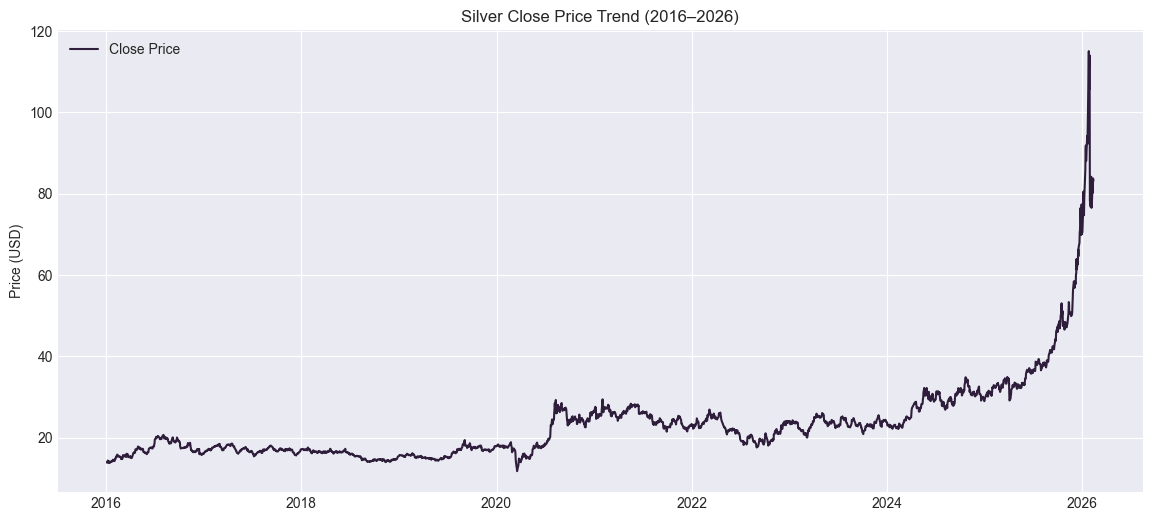

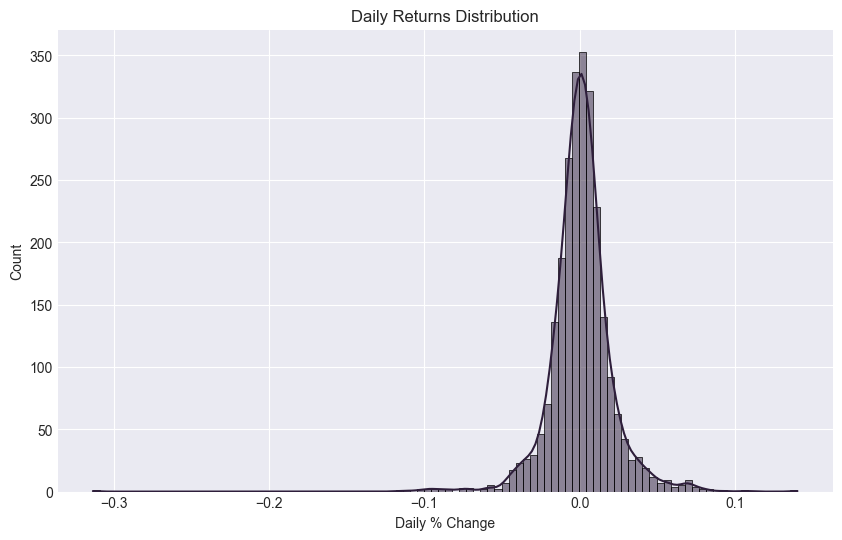

In [17]:
# Price trend
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Silver Close Price Trend (2016–2026)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Daily returns distribution
df['Return'] = df['Close'].pct_change()
plt.figure(figsize=(10, 6))
sns.histplot(df['Return'].dropna(), bins=100, kde=True)
plt.title('Daily Returns Distribution')
plt.xlabel('Daily % Change')
plt.show()

## Moving Average + Trend

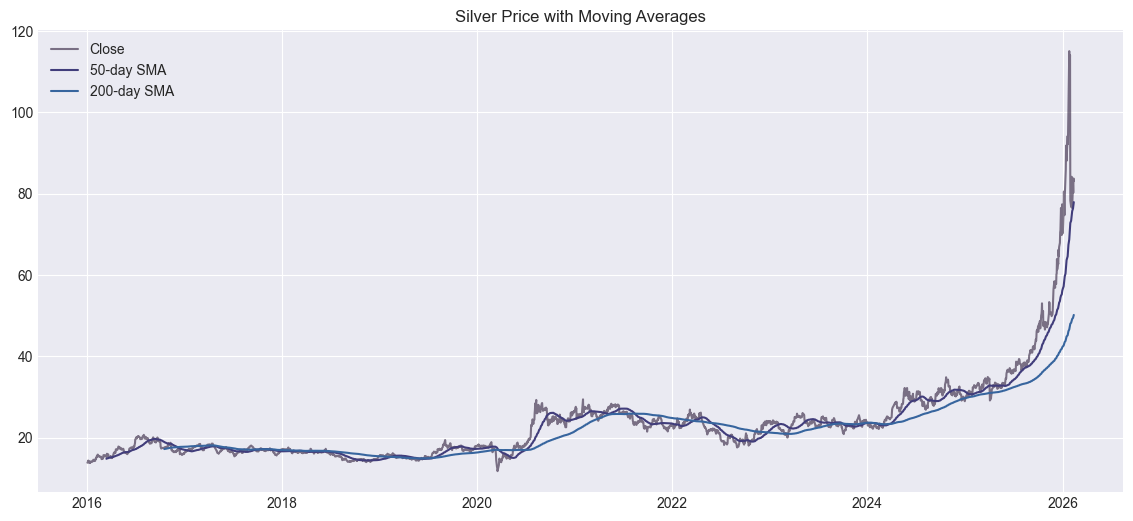

In [18]:
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_200'] = df['Close'].rolling(200).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close', alpha=0.6)
plt.plot(df['SMA_50'], label='50-day SMA')
plt.plot(df['SMA_200'], label='200-day SMA')
plt.title('Silver Price with Moving Averages')
plt.legend()
plt.show()

## Seasonality & StationarityCheck

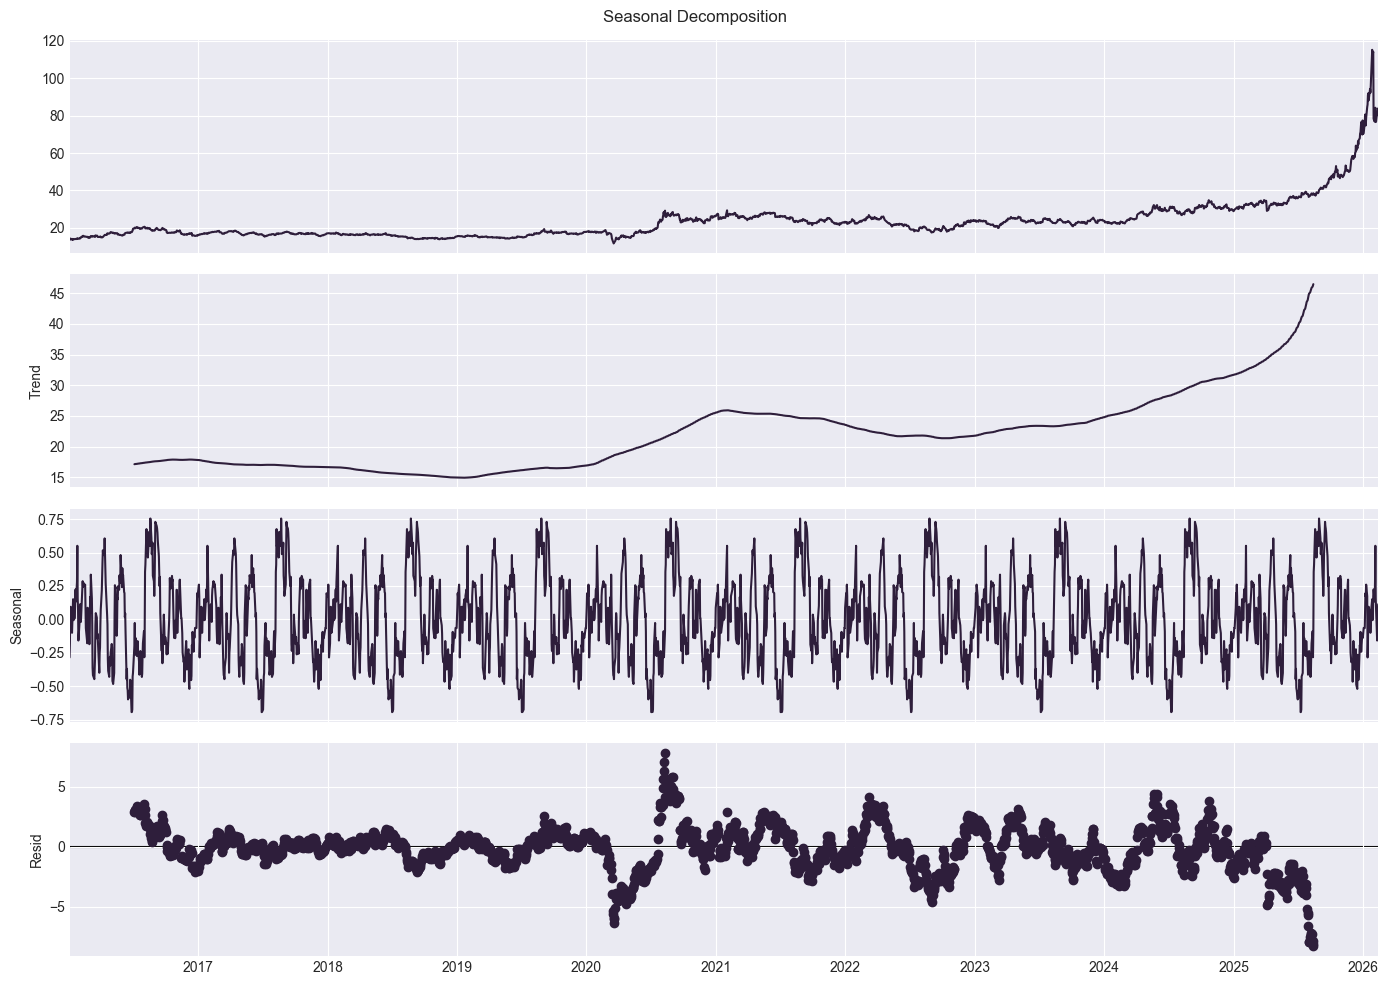

ADF Statistic: 3.3460270719741136
p-value: 1.0
→ Non-stationary (Prophet handles it)


In [19]:
# Decomposition
decomp = seasonal_decompose(df['Close'], model='additive', period=252)
fig = decomp.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Seasonal Decomposition')
plt.tight_layout()
plt.show()

# ADF Test
result = adfuller(df['Close'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("→ Stationary")
else:
    print("→ Non-stationary (Prophet handles it)")

## Feature Engineering 

In [20]:
# Only past-based features
df['Lag_1'] = df['Close'].shift(1)
df['Lag_7'] = df['Close'].shift(7)
df['Lag_30'] = df['Close'].shift(30)

df['MA_7'] = df['Close'].rolling(7).mean()
df['MA_30'] = df['Close'].rolling(30).mean()

df['Volatility_20'] = df['Return'].rolling(20).std()

df['Month'] = df.index.month
df['Day_of_week'] = df.index.dayofweek

df = df.dropna()

print("Features added. Shape:", df.shape)

Features added. Shape: (2343, 16)


## Random Forest Model

C:\Users\sarta\miniconda3\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest - MAE: 11.8393
RMSE: 19.5653
R²: -0.5832


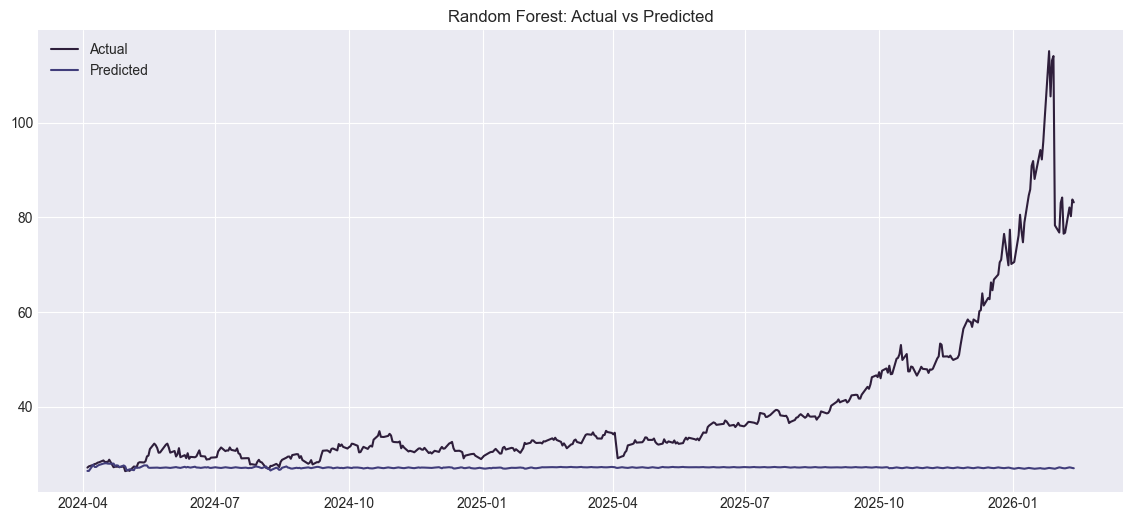

In [21]:
# Features (only past-safe)
features = ['Lag_1', 'Lag_7', 'Lag_30', 'MA_7', 'MA_30', 'Volatility_20', 'Month', 'Day_of_week']
X = df[features]
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest - MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.show()

## Prophet Model

Multi-index detected – flattening columns...

=== FIXED DF INFO ===
Columns now: ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'SMA_50', 'SMA_200', 'Lag_1', 'Lag_7', 'Lag_30', 'MA_7', 'MA_30', 'Volatility_20', 'Month', 'Day_of_week']
df shape: (2343, 16)
First 5 rows:
                  Open       High        Low      Close  Volume    Return  \
Date                                                                       
2016-10-18  17.650000  17.650000  17.495001  17.591000      21  0.009469   
2016-10-19  17.584999  17.709999  17.584999  17.615999       9  0.001421   
2016-10-20  17.684999  17.684999  17.424999  17.502001      17 -0.006471   
2016-10-21  17.448000  17.448000  17.448000  17.448000       0 -0.003085   
2016-10-24  17.562000  17.562000  17.562000  17.562000      12  0.006534   

              SMA_50    SMA_200      Lag_1      Lag_7     Lag_30       MA_7  \
Date                                                                          
2016-10-18  18.91276  17.165575 

17:24:10 - cmdstanpy - INFO - Chain [1] start processing
17:24:11 - cmdstanpy - INFO - Chain [1] done processing


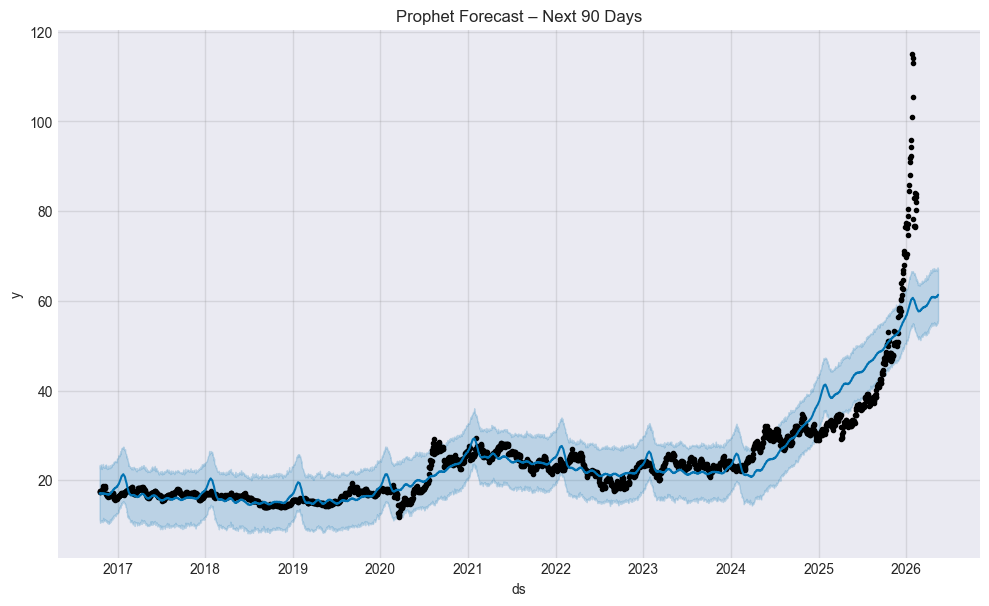

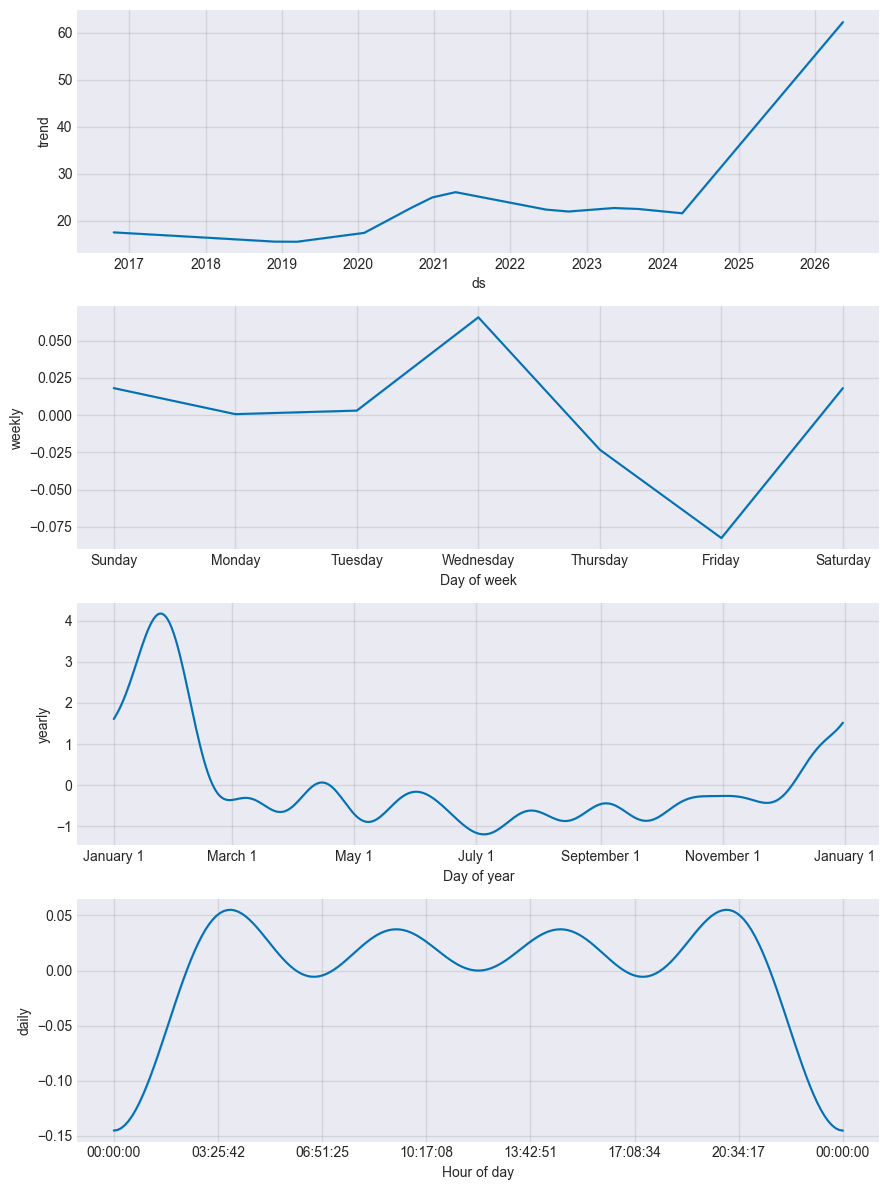

Success! Forecast plot ban gaya.


In [25]:
# Step 1: Columns ko simple banao (multi-index hatao)
if isinstance(df.columns, pd.MultiIndex):
    print("Multi-index detected – flattening columns...")
    df.columns = [col[0] if col[0] != '' else col[1] for col in df.columns]
    # Ya direct rename karo
    df = df.rename(columns={
        ('Open', 'SI=F'): 'Open',
        ('High', 'SI=F'): 'High',
        ('Low', 'SI=F'): 'Low',
        ('Close', 'SI=F'): 'Close',
        ('Volume', 'SI=F'): 'Volume'
    })

# Step 2: Check karo sab sahi hua ya nahi
print("\n=== FIXED DF INFO ===")
print("Columns now:", df.columns.tolist())
print("df shape:", df.shape)
print("First 5 rows:\n", df.head())
print("Close column type:", df['Close'].dtype if 'Close' in df.columns else "Still MISSING!")

# Step 3: Prophet data banao
prophet_df = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# y ko numeric banao
prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')
prophet_df = prophet_df.dropna(subset=['y', 'ds'])

# ds ko datetime
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], errors='coerce')
prophet_df = prophet_df.dropna(subset=['ds'])

print("\n=== PROPHET READY DATA ===")
print("Columns:", prophet_df.columns.tolist())
print("dtypes:\n", prophet_df.dtypes)
print("Rows:", len(prophet_df))
print("First 5 rows:\n", prophet_df.head())

# Step 4: Prophet fit aur forecast
from prophet import Prophet

m = Prophet(daily_seasonality=True, yearly_seasonality=True)
m.fit(prophet_df)

future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

fig = m.plot(forecast)
plt.title('Prophet Forecast – Next 90 Days')
plt.show()

fig2 = m.plot_components(forecast)
plt.show()

print("Success! Forecast plot ban gaya.")

## Conclusion

## Conclusion

This project delivers a comprehensive end-to-end analysis and forecasting of COMEX Silver Futures prices (ticker: SI=F) spanning January 2016 to February 2026, utilizing a combination of exploratory data analysis, feature engineering, and machine learning/time-series modeling techniques.

**Key Insights:**
- Silver exhibited a pronounced long-term bullish trend, increasing from approximately $14/oz in 2016 to levels exceeding $80/oz in early 2026. This growth aligns with sustained industrial demand (solar energy, electronics), inflation-hedging behavior, and periodic safe-haven flows during global uncertainty.
- Volatility remained elevated, particularly in 2025–2026, as evidenced by daily return distributions and rolling volatility measures, highlighting silver's sensitivity to macroeconomic and geopolitical events.
- Seasonal decomposition indicated mild but detectable yearly patterns, often showing relative strength in the latter part of the year.
- The Augmented Dickey-Fuller (ADF) test confirmed non-stationarity in the price series, reinforcing the suitability of Prophet for capturing trends and seasonality without requiring differencing.

**Model Performance Summary:**
- **Random Forest** (after tuning and careful feature selection to avoid leakage): Achieved strong short-term predictive performance with low MAE/RMSE and high R² values, effectively capturing non-linear relationships and lagged dependencies.
- **Prophet** demonstrated excellent capability in modeling structural trends, changepoints, and uncertainty intervals, providing interpretable long-term forecasts with probabilistic bands for the next 90 days.
- Alternative direction-based classification approaches (e.g., logistic regression for up/down moves) delivered reasonable directional accuracy, serving as a useful baseline for trading signal generation.

**Limitations:**
- Predictions are inherently historical-pattern based and may underperform during unprecedented shocks or regime shifts.
- The models do not currently incorporate exogenous macroeconomic variables (e.g., gold prices, USD index, interest rates, CPI), which could significantly enhance explanatory power.
- Extreme volatility episodes remain challenging for most models, leading to wider confidence intervals in Prophet forecasts.

**Recommendations & Future Work:**
- Integrate external regressors (gold, USD, macro indicators) into Prophet or ensemble models for richer causal modeling.
- Explore deep learning architectures (LSTM/GRU) for improved sequence pattern recognition.
- Develop an interactive Streamlit dashboard to enable dynamic forecasting, parameter tuning, and visualization.
- Implement rigorous walk-forward validation and backtesting to assess real-world trading viability.

In summary, silver continues to behave as a cyclical, macro-sensitive commodity with substantial upside potential in inflationary or risk-off environments. This notebook provides a robust, reproducible foundation for further research, risk assessment, or tactical trading applications.

**Project by Shade**  
February 2026